## Курсовая работа по курсу "Видеокурс от Мегафона".

### Загрузка и подготовка данных <a class='anchor' id='load'>

Задача:

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 

Итого, в качестве входных данных будут представлены:
●	data_train.csv: id, vas_id, buy_time, target
●	features.csv.zip: id, <feature_list> 

И тестовый набор:
●	data_test.csv: id, vas_id, buy_time

target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.


Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).


In [1]:
from tqdm import tqdm
import time
import os
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted


# plt.style.use('fivethirtyeight')
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, \
                            classification_report, plot_confusion_matrix, plot_precision_recall_curve, \
                            precision_recall_curve, plot_roc_curve)

# import xgboost as xgb
import catboost as cb
# import lightgbm as lgb
# from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split

#!pip install catboost
# conda install scikit-learn
# !pip install scikit-learn==0.22
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from datetime import datetime

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))
    return df


def get_classification_report(y_train_true, y_train_pred_proba, y_test_true, y_test_pred_proba, threshold=0.5):
    y_train_pred = y_train_pred_proba > threshold
    y_test_pred = y_test_pred_proba > threshold
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels, focus):
    preds_with_true_labels = np.array(
        list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold)), average='macro'))

    scores_table = pd.DataFrame({'f1': f1_scores,
                                 'precision': precisions,
                                 'recall': recalls,
                                 'probability': thresholds}).sort_values('f1', ascending=False).round(4)

    thresholds2 = []
    precisions2 = []
    recalls2 = []
    f1_scores2 = []

    for threshold2 in np.linspace(focus-0.015, focus+0.015, 15):
        thresholds2.append(threshold2)
        precisions2.append(precision_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2))))
        recalls2.append(recall_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2))))
        f1_scores2.append(f1_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2)), average='macro'))

    scores_table2 = pd.DataFrame({'f1': f1_scores2,
                                  'precision': precisions2,
                                  'recall': recalls2,
                                  'probability': thresholds2}).sort_values('f1', ascending=False).round(3)
    maxf1_proba = scores_table2.iloc[0, 3]

    figure = plt.figure(figsize=(15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.plot((maxf1_proba, maxf1_proba), (0, 1), 'g--')
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))
    plt1.table(cellText=scores_table.values,
               colLabels=scores_table.columns,
               colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0],
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    plt2.table(cellText=scores_table2.values,
               colLabels=scores_table2.columns,
               colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])
    plt.savefig('proba_calibration.png')
    plt.show()
    return maxf1_proba

In [3]:
train = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

In [4]:
train.id.unique()

array([ 540968, 1454121, 2458816, ...,  158236, 1825525, 3022610])

In [5]:
list_id = set(train.id.unique().tolist() + test.id.unique().tolist())

In [6]:
features = dd.read_csv('features.csv', sep='\t')

In [7]:
df_features = features[features.id.isin(list_id)].drop('Unnamed: 0', axis=1).compute()

In [11]:
%%time
df = pd.merge_asof(train.sort_values('buy_time').rename(columns={'buy_time': 'buy_time_start'}),
              df_features.sort_values('buy_time').rename(columns={'buy_time': 'buy_time_offer'}), by='id', direction='nearest', left_on='buy_time_start', right_on='buy_time_offer')
df

CPU times: user 5.71 s, sys: 25.6 s, total: 31.3 s
Wall time: 31.7 s


,id,vas_id,buy_time_start,target,buy_time_offer,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,1531083600,0.0,1544994000,314.560029,9.290888,342.989214,7.523202,337.571754,...,6488.626154,-574.770792,-24.996269,121.369552,142.252276,-16.832889,-0.694428,-11.175933,-0.45614,0.0
1,1292549,2.0,1531083600,0.0,1537131600,93.880029,-217.499112,79.939214,-270.106798,74.521754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,4053116,1.0,1531083600,0.0,1535317200,125.110029,152.190888,111.169214,107.213202,105.751754,...,-956.373846,-613.770792,-18.996269,761.369552,-213.747724,26.167111,-0.694428,39.824067,-0.45614,1.0
3,4158361,2.0,1531083600,0.0,1538341200,-7.829971,-266.839112,-20.500786,-304.196798,-25.918246,...,1257.626154,495.229208,-19.996269,-37.630448,-108.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
4,3754468,4.0,1531083600,0.0,1545598800,83.620029,535.610888,72.219214,503.343202,66.801754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,555080,5.0,1546203600,0.0,1536526800,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
831649,1729471,5.0,1546203600,0.0,1545598800,-86.209971,-397.589112,-100.150786,-450.196798,-105.568246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
831650,3676177,2.0,1546203600,0.0,1535922000,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
831651,2255038,2.0,1546203600,0.0,1539550800,-96.799971,49.450888,-104.390786,219.293202,-109.808246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [12]:
df.to_csv('df.csv', index=False)

### Просмотр, анализ данных, базовая модель <a class='anchor' id='analys'>

In [4]:
%%time
df = reduce_mem_usage(pd.read_csv('df.csv'))

Memory usage of dataframe is 1637.01 MB
Memory usage after optimization is: 818.51 MB
Decreased by 50.0%
CPU times: user 1min 7s, sys: 20.6 s, total: 1min 28s
Wall time: 1min 29s


In [5]:
# Запустить, если выполнение тетрадки осуществляется с данного блока (просмотр и анализ данных)
train = pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

In [6]:
df['target'].value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

In [7]:
df

,id,vas_id,buy_time_start,target,buy_time_offer,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,1531083600,0.0,1544994000,314.560028,9.290888,342.989227,7.523202,337.571747,...,6488.625977,-574.770813,-24.996269,121.369553,142.252274,-16.832888,-0.694429,-11.175933,-0.45614,0.0
1,1292549,2.0,1531083600,0.0,1537131600,93.880028,-217.499115,79.939217,-270.106812,74.521751,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
2,4053116,1.0,1531083600,0.0,1535317200,125.110031,152.190887,111.169212,107.213203,105.751755,...,-956.373840,-613.770813,-18.996269,761.369568,-213.747726,26.167112,-0.694429,39.824066,-0.45614,1.0
3,4158361,2.0,1531083600,0.0,1538341200,-7.829971,-266.839111,-20.500786,-304.196808,-25.918247,...,1257.626099,495.229218,-19.996269,-37.630447,-108.747726,-25.832888,-0.694429,-12.175933,-0.45614,1.0
4,3754468,4.0,1531083600,0.0,1545598800,83.620026,535.610901,72.219215,503.343201,66.801750,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831648,555080,5.0,1546203600,0.0,1536526800,-96.799973,-408.179108,-110.740784,-460.786804,-116.158249,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
831649,1729471,5.0,1546203600,0.0,1545598800,-86.209969,-397.589111,-100.150787,-450.196808,-105.568245,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
831650,3676177,2.0,1546203600,0.0,1535922000,-96.799973,-408.179108,-110.740784,-460.786804,-116.158249,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
831651,2255038,2.0,1546203600,0.0,1539550800,-96.799973,49.450890,-104.390785,219.293198,-109.808243,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0


In [8]:
train

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0
...,...,...,...,...
831648,3812226,2.0,1546203600,0.0
831649,2480469,2.0,1546203600,0.0
831650,158236,2.0,1546203600,0.0
831651,1825525,2.0,1546203600,0.0


In [9]:
train['id'].nunique()

806613

In [10]:
df.describe()

,id,vas_id,buy_time_start,target,buy_time_offer,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
count,8.316530e+05,831653.000000,8.316530e+05,831653.000000,8.316530e+05,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,...,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000
mean,2.158304e+06,2.686185,1.538937e+09,0.072369,1.539515e+09,0.301304,1.801172,0.237123,2.066911,0.262526,...,0.548182,0.861794,0.376409,-0.060826,-1.191119,0.017000,-0.032236,0.205423,0.006831,0.258348
std,1.257907e+06,1.952034,5.019053e+06,0.259098,5.317633e+06,299.521179,491.218567,306.206848,555.532898,318.280334,...,3188.381104,2229.624756,1362.344971,300.972656,1293.871948,265.417084,7.032948,204.421036,11.730679,2.095543
min,2.000000e+00,1.000000,1.531084e+09,0.000000,1.531084e+09,-1151.890015,-1594.119141,-2651.840820,-1634.436768,-2657.258301,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.000000
25%,1.067319e+06,1.000000,1.534108e+09,0.000000,1.534712e+09,-96.799973,-208.339111,-110.740784,-242.146805,-116.158249,...,-977.373840,-613.770813,-25.996269,-37.630447,-305.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.000000
50%,2.144574e+06,2.000000,1.538341e+09,0.000000,1.539551e+09,-84.939972,-59.029114,-85.300789,-77.866798,-87.608246,...,-958.373840,-613.770813,-25.996269,-37.630447,-239.747726,-23.832888,-0.694429,-12.175933,-0.456140,0.000000
75%,3.244254e+06,4.000000,1.544389e+09,0.000000,1.544994e+09,11.850029,120.620888,27.439215,128.733200,29.161755,...,-482.373840,-405.770782,-24.996269,-32.630447,-77.747726,-10.832889,-0.694429,-9.175933,-0.456140,1.000000
max,4.362694e+06,9.000000,1.546204e+09,1.000000,1.548018e+09,211730.718750,212606.125000,211716.781250,213357.750000,212095.265625,...,173834.625000,145602.234375,980158.000000,47086.371094,185850.250000,138539.171875,2285.305664,138552.828125,9489.543945,1743.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Columns: 258 entries, id to 252
dtypes: float32(255), int32(3)
memory usage: 818.5 MB


#### Модель на первоначальных данных train <a class='anchor' id='train1'>

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=train['target']
                                                   )

In [13]:
# disbalance = train['target'].value_counts()[0] / train['target'].value_counts()[1]
# disbalance

In [14]:
cb_params = {
    "n_estimators": 1000,
#     "loss_function": "Logloss",
    "eval_metric": "F1",
#     "task_type": "CPU",
#     "max_bin": 20,
#     "verbose": 25,
#     "max_depth": 6,
#     "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
#     "thread_count": 6,
    "random_seed": 42,
#     "importance_type": 'macro'
}

In [15]:
model_ctb = CatBoostClassifier(**cb_params)
model_ctb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=100)

Learning rate set to 0.147007
0:	learn: 0.0484914	test: 0.0484914	test1: 0.0501575	best: 0.0501575 (0)	total: 115ms	remaining: 1m 54s
100:	learn: 0.3978490	test: 0.3978490	test1: 0.3921337	best: 0.3921453 (78)	total: 5.23s	remaining: 46.5s
200:	learn: 0.4091015	test: 0.4091015	test1: 0.3963080	best: 0.3963080 (200)	total: 10.1s	remaining: 40s
300:	learn: 0.4126806	test: 0.4126806	test1: 0.3952225	best: 0.3971582 (297)	total: 14.9s	remaining: 34.5s
400:	learn: 0.4177634	test: 0.4177634	test1: 0.3991186	best: 0.3993275 (399)	total: 19.7s	remaining: 29.4s
500:	learn: 0.4207091	test: 0.4207091	test1: 0.4004740	best: 0.4004740 (500)	total: 24.6s	remaining: 24.5s
600:	learn: 0.4232820	test: 0.4232820	test1: 0.4006346	best: 0.4009577 (576)	total: 29.4s	remaining: 19.5s
700:	learn: 0.4249416	test: 0.4249416	test1: 0.4014413	best: 0.4033329 (622)	total: 34.2s	remaining: 14.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4033328545
bestIteration = 622

Shrink model to fir

In [16]:
y_pred_cb_train = model_ctb.predict_proba(X_train)[:,1]
y_pred_cb_valid = model_ctb.predict_proba(X_valid)[:,1]

print(f" {get_classification_report(y_train,y_pred_cb_train, y_valid, y_pred_cb_valid, threshold=0.5)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    462879
         1.0       0.69      0.31      0.43     36112

    accuracy                           0.94    498991
   macro avg       0.82      0.65      0.70    498991
weighted avg       0.93      0.94      0.93    498991

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    308588
         1.0       0.65      0.29      0.40     24074

    accuracy                           0.94    332662
   macro avg       0.80      0.64      0.69    332662
weighted avg       0.93      0.94      0.93    332662

 None


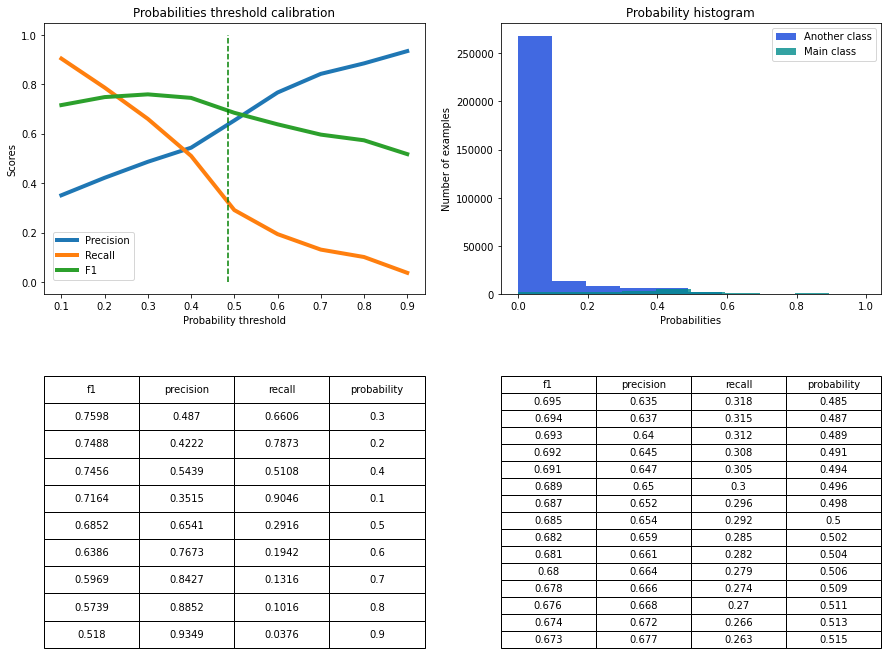

CPU times: user 19.8 s, sys: 778 ms, total: 20.6 s
Wall time: 19.7 s


0.485

In [17]:
%%time
show_proba_calibration_plots(y_pred_cb_valid, y_valid, focus=0.5)

In [18]:
# Линейная модель

In [19]:
%%time
model_lasso = Lasso()

model_lasso.fit(X_train, y_train)

y_pred_lasso_train = model_lasso.predict(X_train)
y_pred_lasso_valid = model_lasso.predict(X_valid)

print(f" {get_classification_report(y_train, y_pred_lasso_train, y_valid, y_pred_lasso_valid, threshold=0.1)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.82    462879
         1.0       0.13      0.55      0.21     36112

    accuracy                           0.70    498991
   macro avg       0.54      0.63      0.51    498991
weighted avg       0.89      0.70      0.77    498991

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.71      0.81    308588
         1.0       0.13      0.54      0.21     24074

    accuracy                           0.70    332662
   macro avg       0.54      0.63      0.51    332662
weighted avg       0.89      0.70      0.77    332662

 None
CPU times: user 1.84 s, sys: 1.18 s, total: 3.02 s
Wall time: 1.61 s


In [20]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

y_pred_ridge_train = model_ridge.predict(X_train)
y_pred_ridge_valid = model_ridge.predict(X_valid)

print(f" {get_classification_report(y_train, y_pred_ridge_train, y_valid, y_pred_ridge_valid, threshold=0.2)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    462879
         1.0       0.26      0.26      0.26     36112

    accuracy                           0.89    498991
   macro avg       0.60      0.60      0.60    498991
weighted avg       0.89      0.89      0.89    498991

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    308588
         1.0       0.26      0.26      0.26     24074

    accuracy                           0.89    332662
   macro avg       0.60      0.60      0.60    332662
weighted avg       0.89      0.89      0.89    332662

 None


#### Модель на первоначальных данных train и профиле потребления клиента <a class='anchor' id='train2'>

In [21]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(df.drop('target', axis=1), df['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=df['target']
                                                   )

In [22]:
model_ctb2 = CatBoostClassifier(**cb_params)
model_ctb2.fit(X_train2, y_train2, eval_set=[(X_train2, y_train2), (X_valid2, y_valid2)], verbose=100)

Learning rate set to 0.147007
0:	learn: 0.3710440	test: 0.3710440	test1: 0.3711005	best: 0.3711005 (0)	total: 134ms	remaining: 2m 13s
100:	learn: 0.4061994	test: 0.4061994	test1: 0.3959477	best: 0.3959477 (100)	total: 12.9s	remaining: 1m 54s
200:	learn: 0.4233653	test: 0.4233653	test1: 0.4004655	best: 0.4012094 (189)	total: 24.5s	remaining: 1m 37s
300:	learn: 0.4398280	test: 0.4398280	test1: 0.4023038	best: 0.4032249 (264)	total: 36.5s	remaining: 1m 24s
400:	learn: 0.4550680	test: 0.4550680	test1: 0.4044395	best: 0.4048290 (398)	total: 48.4s	remaining: 1m 12s
500:	learn: 0.4686876	test: 0.4686876	test1: 0.4066973	best: 0.4075377 (484)	total: 1m	remaining: 1m
600:	learn: 0.4820336	test: 0.4820336	test1: 0.4074663	best: 0.4084023 (586)	total: 1m 13s	remaining: 48.5s
700:	learn: 0.4952990	test: 0.4952990	test1: 0.4097238	best: 0.4097354 (699)	total: 1m 25s	remaining: 36.6s
800:	learn: 0.5076673	test: 0.5076673	test1: 0.4105411	best: 0.4117315 (763)	total: 1m 38s	remaining: 24.5s
Stopped b

In [23]:
y_pred_cb_train2 = model_ctb2.predict_proba(X_train2)[:,1]
y_pred_cb_valid2 = model_ctb2.predict_proba(X_valid2)[:,1]

print(f" {get_classification_report(y_train2, y_pred_cb_train2, y_valid2, y_pred_cb_valid2, threshold=0.5)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    462879
         1.0       0.76      0.38      0.50     36112

    accuracy                           0.95    498991
   macro avg       0.86      0.68      0.74    498991
weighted avg       0.94      0.95      0.94    498991

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    308588
         1.0       0.64      0.30      0.41     24074

    accuracy                           0.94    332662
   macro avg       0.79      0.64      0.69    332662
weighted avg       0.93      0.94      0.93    332662

 None


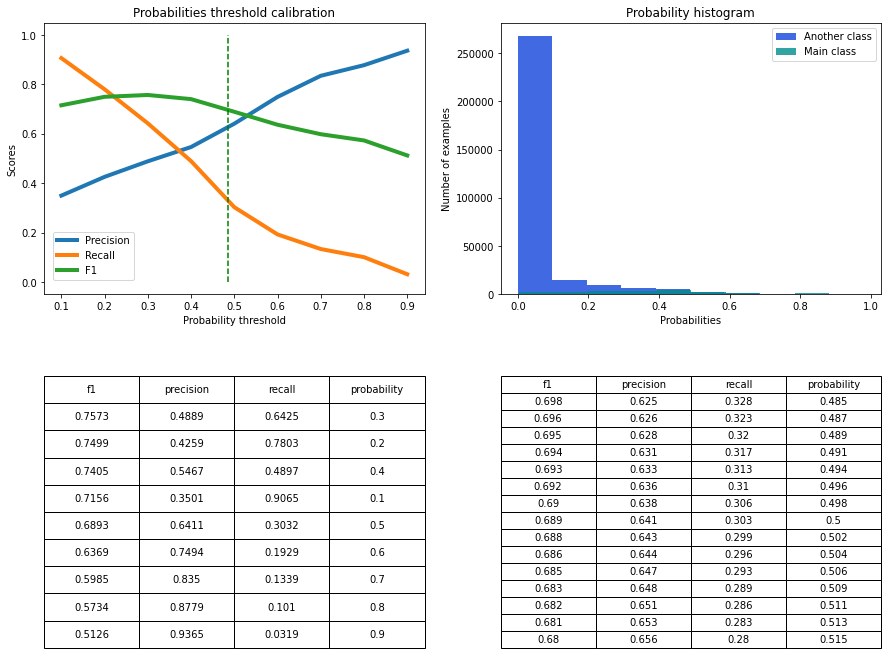

CPU times: user 20.2 s, sys: 746 ms, total: 20.9 s
Wall time: 20.1 s


0.485

In [24]:
%%time
show_proba_calibration_plots(y_pred_cb_valid2, y_valid2, focus=0.5)

#### Модель на профиле потребления клиента <a class='anchor' id='train3'>

In [25]:
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(df.drop(['target', 'vas_id', 'buy_time_start'], axis=1),
                                                          df['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=df['target']
                                                   )

In [26]:
model_ctb3 = CatBoostClassifier(**cb_params)
model_ctb3.fit(X_train3, y_train3, eval_set=[(X_train3, y_train3), (X_valid3, y_valid3)], verbose=100)

Learning rate set to 0.147007
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 114ms	remaining: 1m 53s
100:	learn: 0.0000554	test: 0.0000554	test1: 0.0000000	best: 0.0000000 (0)	total: 12.8s	remaining: 1m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.


In [27]:
# Из результатов модели видно, что данные о профиле потребления клиента(все 252 признака) не дают какого-либо 
#  прироста информации для "деревянной" модели.

In [28]:
%%time
model_lasso = Lasso()

model_lasso.fit(X_train3, y_train3)

CPU times: user 15.3 s, sys: 1.54 s, total: 16.8 s
Wall time: 2.99 s


Lasso()

In [29]:
y_pred_lasso_train = model_lasso.predict(X_train3)
y_pred_lasso_valid = model_lasso.predict(X_valid3)

print(f" {get_classification_report(y_train3, y_pred_lasso_train, y_valid3, y_pred_lasso_valid, threshold=0.5)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    462879
         1.0       0.00      0.00      0.00     36112

    accuracy                           0.93    498991
   macro avg       0.46      0.50      0.48    498991
weighted avg       0.86      0.93      0.89    498991

TEST

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    308588
         1.0       0.00      0.00      0.00     24074

    accuracy                           0.93    332662
   macro avg       0.46      0.50      0.48    332662
weighted avg       0.86      0.93      0.89    332662

 None


#### Модель на первоначальных данных train и профиле потребления клиента в разбивке по предлагаемым услугам <a class='anchor' id='train4'>

In [30]:
np.sort(df.vas_id.unique())

array([1., 2., 4., 5., 6., 7., 8., 9.], dtype=float32)

Learning rate set to 0.115223
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 43.6ms	remaining: 43.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.380343123
bestIteration = 200

Shrink model to first 201 iterations.
Разбивка по услуге № 1.0 (отсечка 0.5) -------------->


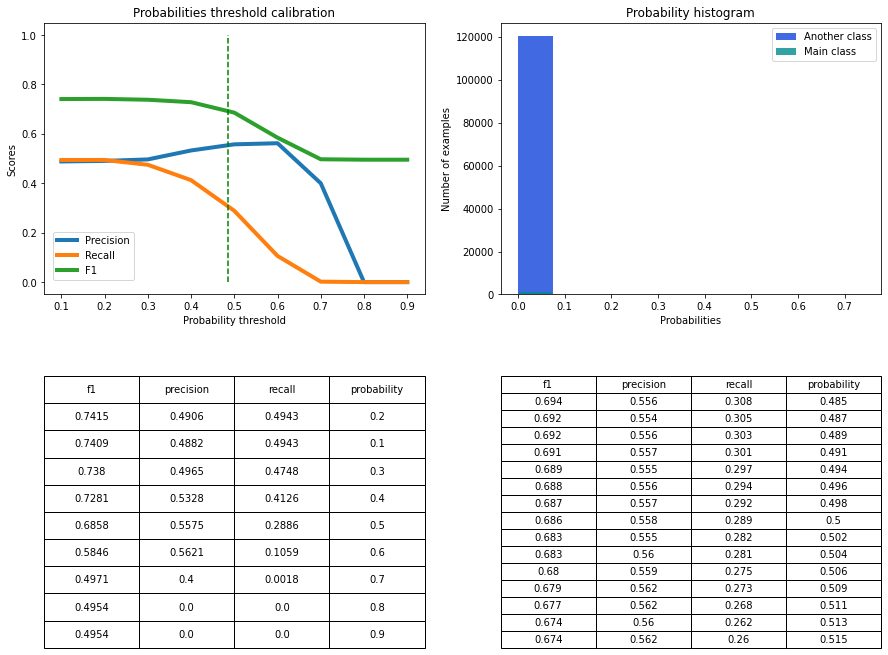

Learning rate set to 0.109192
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 43.3ms	remaining: 43.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5952987822
bestIteration = 108

Shrink model to first 109 iterations.
Разбивка по услуге № 2.0 (отсечка 0.5) -------------->


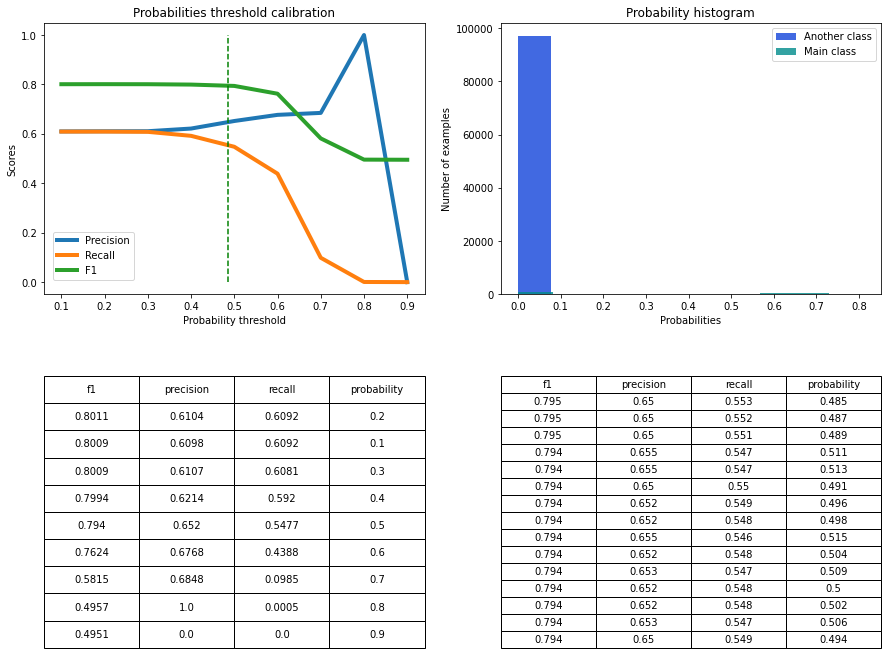

Learning rate set to 0.083874
0:	learn: 0.3921614	test: 0.3921614	test1: 0.3887304	best: 0.3887304 (0)	total: 71.1ms	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3887976489
bestIteration = 2

Shrink model to first 3 iterations.
Разбивка по услуге № 4.0 (отсечка 0.5) -------------->


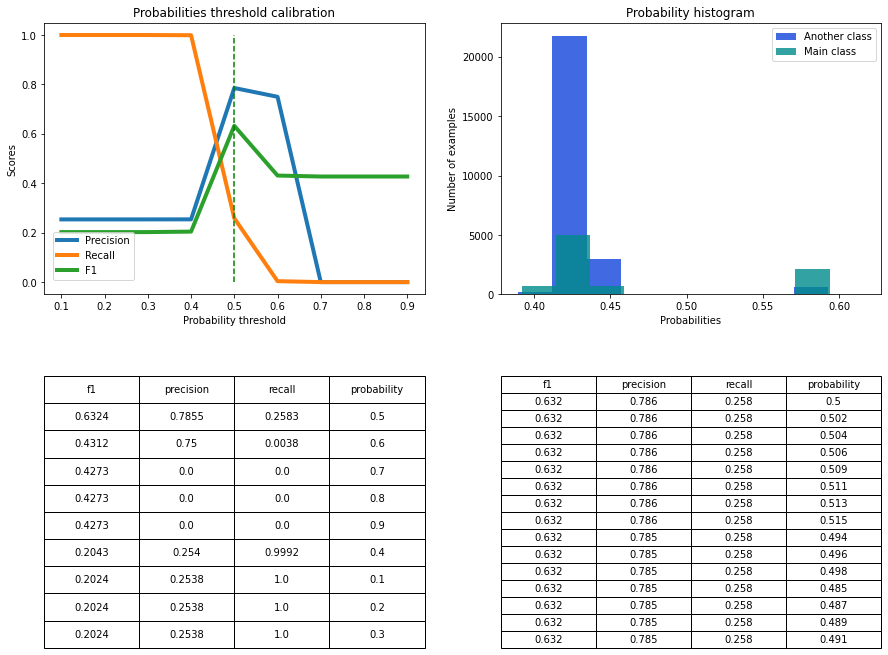

Learning rate set to 0.085817
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 21ms	remaining: 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6162079511
bestIteration = 101

Shrink model to first 102 iterations.
Разбивка по услуге № 5.0 (отсечка 0.5) -------------->


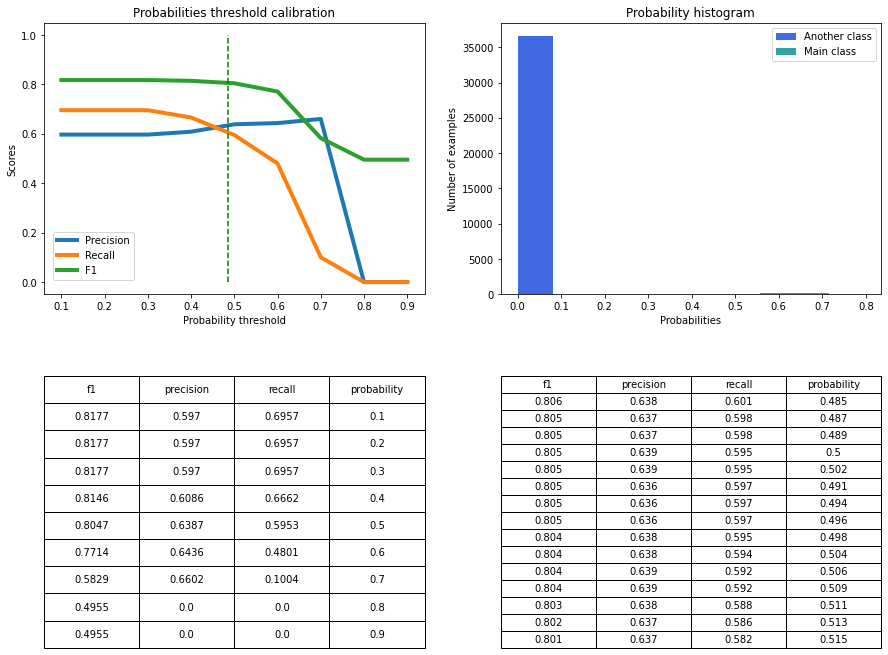

Learning rate set to 0.076112
0:	learn: 0.1124009	test: 0.1124009	test1: 0.1192869	best: 0.1192869 (0)	total: 17.4ms	remaining: 17.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3401322659
bestIteration = 603

Shrink model to first 604 iterations.
Разбивка по услуге № 6.0 (отсечка 0.5) -------------->


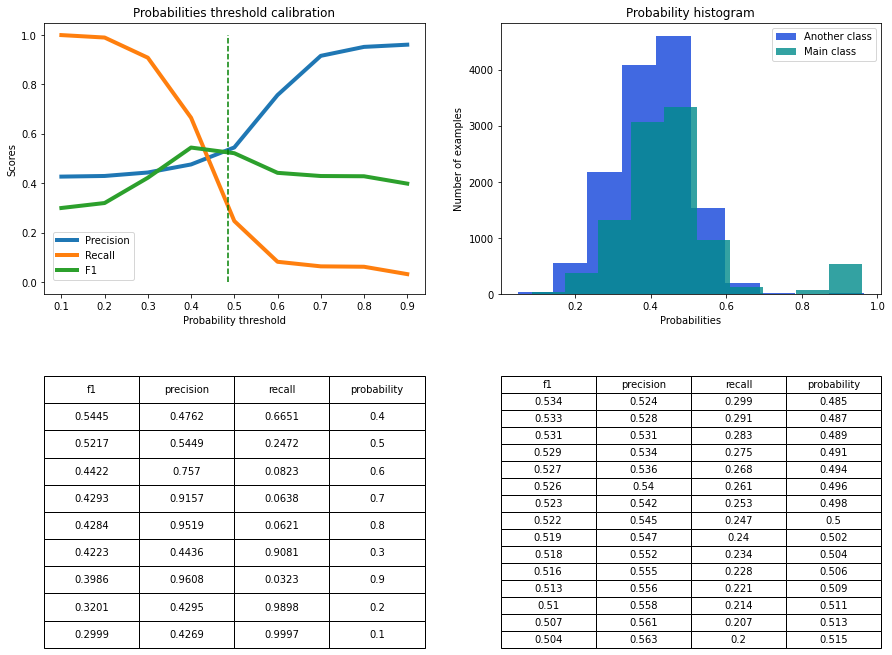

Learning rate set to 0.05491
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 12.4ms	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3880597015
bestIteration = 198

Shrink model to first 199 iterations.
Разбивка по услуге № 7.0 (отсечка 0.5) -------------->


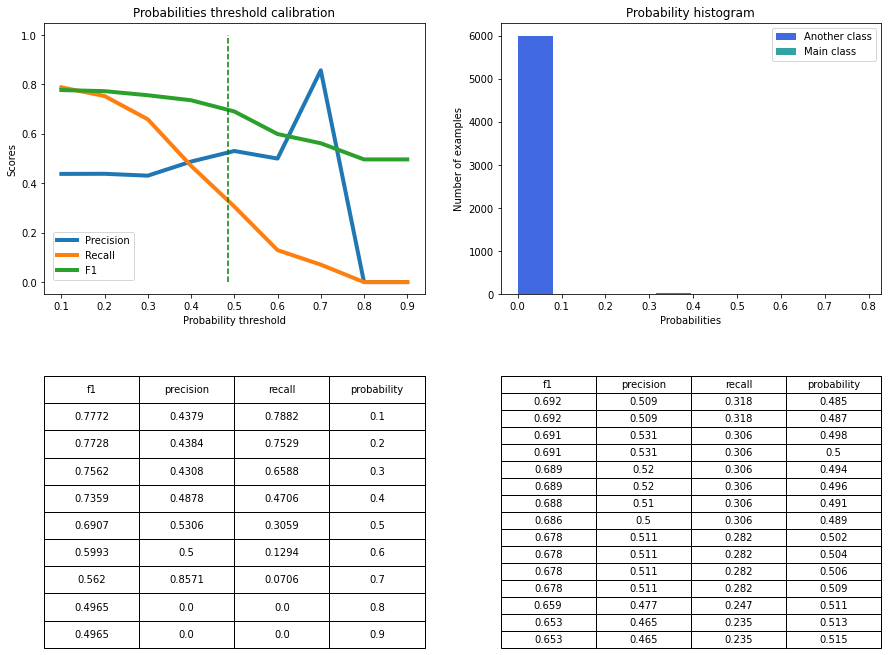

Learning rate set to 0.052979
0:	learn: 0.0000000	test: 0.0000000	test1: 0.0000000	best: 0.0000000 (0)	total: 12ms	remaining: 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7579617834
bestIteration = 45

Shrink model to first 46 iterations.
Разбивка по услуге № 8.0 (отсечка 0.5) -------------->


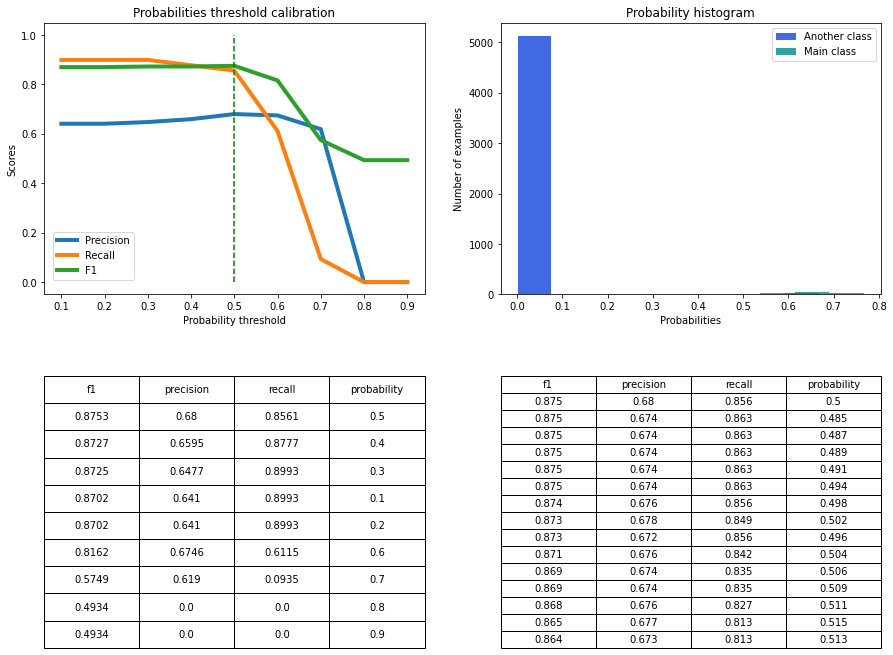

Learning rate set to 0.042504
0:	learn: 0.8788396	test: 0.8788396	test1: 0.8905852	best: 0.8905852 (0)	total: 9.72ms	remaining: 9.71s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8905852417
bestIteration = 0

Shrink model to first 1 iterations.
Разбивка по услуге № 9.0 (отсечка 0.5) -------------->


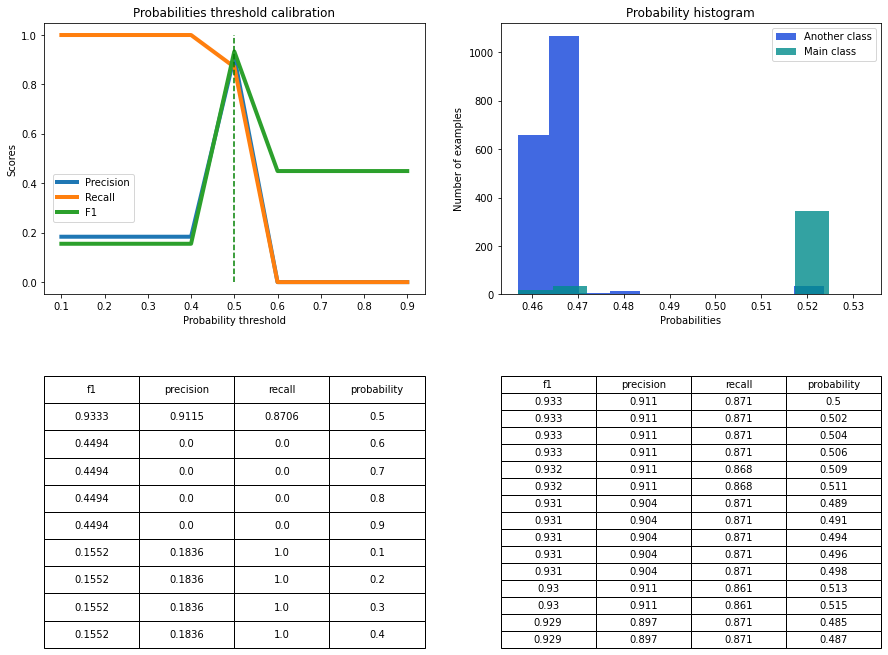

In [31]:
for ii in np.sort(df.vas_id.unique()):
    df_vas = df.copy()
    df_vas = df_vas.loc[df_vas['vas_id'] == ii]
    
    X_train, X_valid, y_train, y_valid = train_test_split(df_vas.drop('target', axis=1), df_vas['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=df_vas['target']
                                                   )
    
    model_ctb = CatBoostClassifier(**cb_params)
    model_ctb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000)
    
    y_pred_cb_train = model_ctb.predict_proba(X_train)[:,1]
    y_pred_cb_valid = model_ctb.predict_proba(X_valid)[:,1]
    print(f'Разбивка по услуге № {ii} (отсечка 0.5) -------------->')
    
    show_proba_calibration_plots(y_pred_cb_valid, y_valid, focus=0.5)

In [32]:
# Как видно из результатов, разбивка по услугам в некоторых случаях повышает метрику, но в то же время в других случаях
#  она остается низкой. 
#   Среднее арифметическое f1_macro всех моделей при подборе лучшей отсечки для каждой услуги(модели) не превышает 0.77.
#    В этой связи метрика, получаемая с помощью разбивки, близка к метрике, получаемой при помощи обучения только на train.


#### Модель на первоначальных данных train в разбивке по неповторяющимся и повторяющимся id (повторные предложения тех же услуг) <a class='anchor' id='train5'>

In [33]:
train['id'].nunique(), len(train['id'])

(806613, 831653)

In [34]:
tmp_df = train.groupby(['id', 'vas_id'], as_index=False).agg({'buy_time': 'count'})
tmp_df

,id,vas_id,buy_time
0,2,2.0,1
1,4,1.0,1
2,15,1.0,1
3,16,2.0,1
4,29,1.0,1
...,...,...,...
825399,4362634,1.0,1
825400,4362640,2.0,1
825401,4362647,6.0,1
825402,4362684,5.0,1


In [35]:
tmp_df['id'].nunique()

806613

In [36]:
tmp_df.loc[tmp_df.buy_time > 1]

,id,vas_id,buy_time
130,610,8.0,2
165,771,4.0,2
230,1168,4.0,2
306,1559,4.0,2
310,1582,4.0,2
...,...,...,...
798467,4217743,1.0,2
803476,4244393,1.0,2
808261,4270769,1.0,2
808340,4271145,6.0,2


In [37]:
# В train ДАТАСЕТЕ НЕТ ТЕХ КЛИЕНТОВ, КОТОРЫМ ОДНА УСЛУГА ПРЕДЛАГАСЬ БОЛЬШЕ 2-х РАЗ.
# <----------

In [38]:
# Этим клиентам услуга предлагалась дважды
repeat_offers = train.loc[(train.id.isin(tmp_df.loc[tmp_df.buy_time > 1]['id'].tolist()))]
repeat_offers

,id,vas_id,buy_time,target
52,675583,2.0,1535317200,0.0
53,675583,2.0,1542574800,1.0
92,1825537,4.0,1532898000,1.0
93,1825537,4.0,1544389200,0.0
322,1010292,1.0,1535317200,0.0
...,...,...,...,...
829444,1498547,6.0,1544994000,1.0
829813,135601,6.0,1544994000,0.0
829814,135601,6.0,1546203600,1.0
829906,428413,6.0,1544994000,0.0


In [39]:
# Этим клиентам услуга предлагалась единожды
not_repeat_offers = train.loc[(~train.id.isin(tmp_df.loc[tmp_df.buy_time > 1]['id'].tolist()))]
not_repeat_offers

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0
...,...,...,...,...
831648,3812226,2.0,1546203600,0.0
831649,2480469,2.0,1546203600,0.0
831650,158236,2.0,1546203600,0.0
831651,1825525,2.0,1546203600,0.0


In [40]:
repeat_offers.target.value_counts()

1.0    6290
0.0    6221
Name: target, dtype: int64

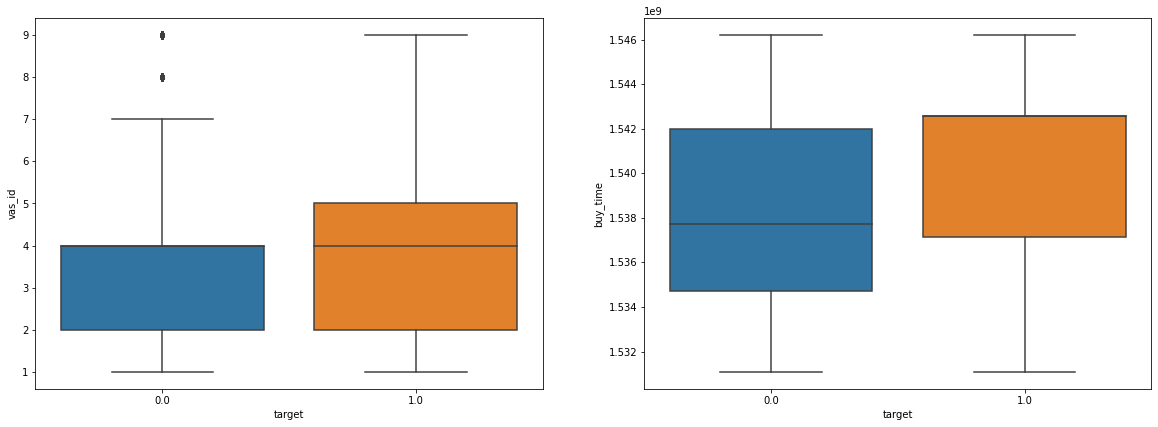

In [41]:
plt.figure(figsize = (20, 15))
for num, feature in enumerate(repeat_offers[['vas_id', 'buy_time']].columns.tolist(), start=1):
    plt.subplot(2, 2, num)
    sns.boxplot(x=repeat_offers['target'], y=feature, data=repeat_offers)

Learning rate set to 0.146458
0:	learn: 0.0535564	test: 0.0535564	test1: 0.0515664	best: 0.0515664 (0)	total: 44.2ms	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3593314763
bestIteration = 98

Shrink model to first 99 iterations.


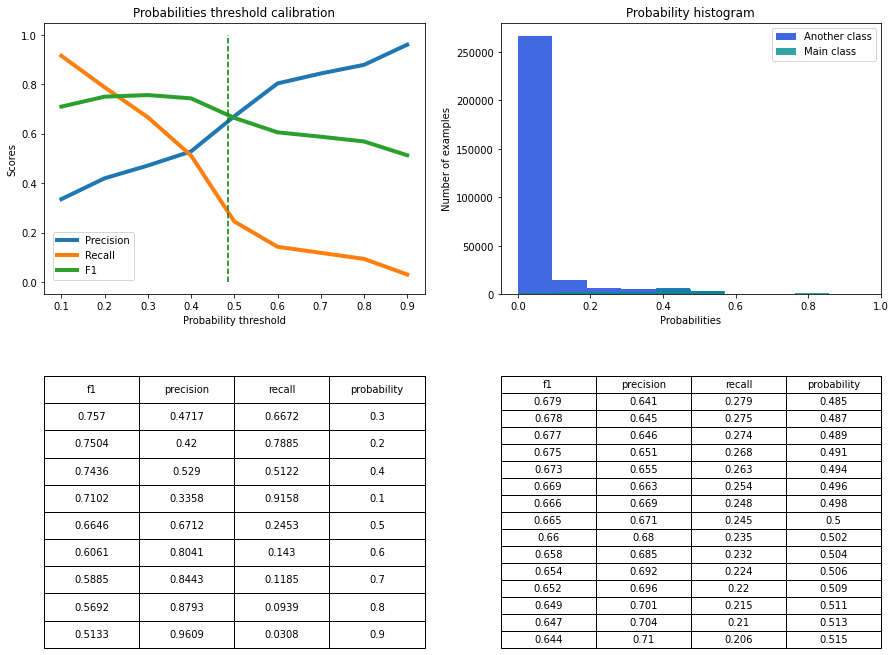

0.485

In [42]:
X_train_not, X_valid_not, y_train_not, y_valid_not = train_test_split(not_repeat_offers.drop('target', axis=1),
                                                                     not_repeat_offers['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=not_repeat_offers['target']
                                                   )
    
model_ctb_not = CatBoostClassifier(**cb_params)
model_ctb_not.fit(X_train_not, y_train_not, eval_set=[(X_train_not, y_train_not), (X_valid_not, y_valid_not)], verbose=1000)
    
y_pred_cb_train_not = model_ctb_not.predict_proba(X_train_not)[:,1]
y_pred_cb_valid_not = model_ctb_not.predict_proba(X_valid_not)[:,1]
  
show_proba_calibration_plots(y_pred_cb_valid_not, y_valid_not, focus=0.5)

Learning rate set to 0.052136
0:	learn: 0.6097872	test: 0.6097872	test1: 0.6077469	best: 0.6077469 (0)	total: 2.01ms	remaining: 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6843685061
bestIteration = 108

Shrink model to first 109 iterations.


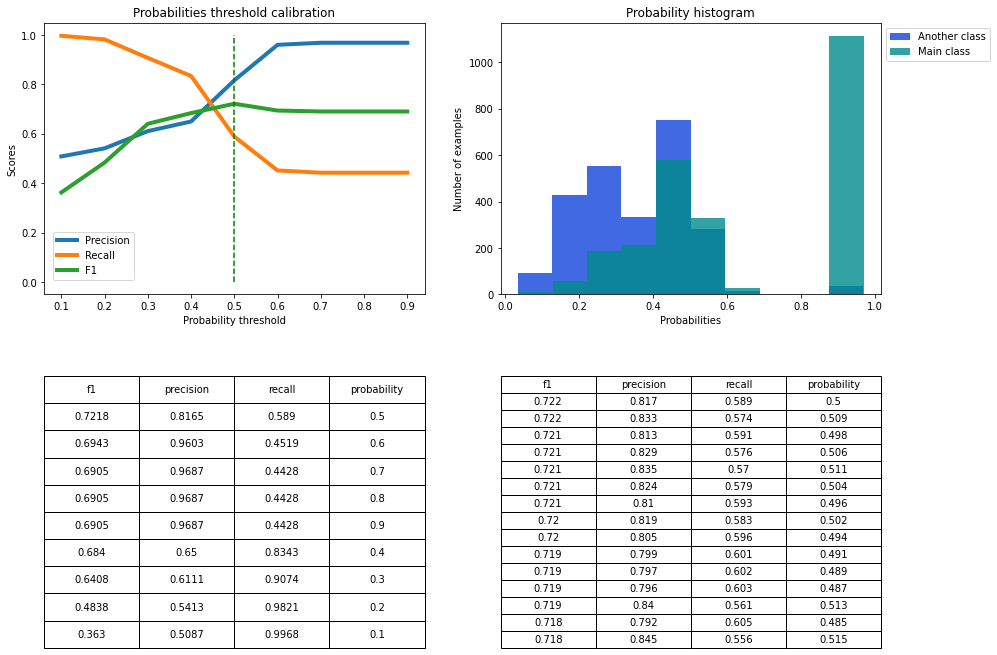

0.5

In [43]:
X_train_is, X_valid_is, y_train_is, y_valid_is = train_test_split(repeat_offers.drop('target', axis=1),
                                                                     repeat_offers['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=repeat_offers['target']
                                                   )
    
model_ctb_is = CatBoostClassifier(**cb_params)
model_ctb_is.fit(X_train_is, y_train_is, eval_set=[(X_train_is, y_train_is), (X_valid_is, y_valid_is)], verbose=1000)
    
y_pred_cb_train_is = model_ctb_is.predict_proba(X_train_is)[:,1]
y_pred_cb_valid_is = model_ctb_is.predict_proba(X_valid_is)[:,1]
  
show_proba_calibration_plots(y_pred_cb_valid_is, y_valid_is, focus=0.5)

In [44]:
# Данная разбивка также не дает прироста в качестве

In [45]:
# Дополнительно исследуем датасет repeat_offers

In [46]:
repeat_offers3 = repeat_offers.copy()

In [47]:
# max
tmp1_repeat_offers3 = repeat_offers3.groupby(['id', 'vas_id'], as_index=False).agg({'buy_time': 'max'})

tmp_max_repeat_offers = pd.merge(tmp1_repeat_offers3, repeat_offers3, on=['id', 'vas_id', 'buy_time'], how='left')
tmp_max_repeat_offers

,id,vas_id,buy_time,target
0,610,8.0,1542574800,1.0
1,771,4.0,1536526800,1.0
2,1168,4.0,1543179600,0.0
3,1559,4.0,1532293200,1.0
4,1582,4.0,1532898000,0.0
...,...,...,...,...
6257,4217743,1.0,1542574800,1.0
6258,4244393,1.0,1537736400,1.0
6259,4270769,1.0,1536526800,0.0
6260,4271145,6.0,1543784400,1.0


In [48]:
# min
tmp1_repeat_offers4 = repeat_offers3.groupby(['id', 'vas_id'], as_index=False).agg({'buy_time': 'min'})

tmp_min_repeat_offers = pd.merge(tmp1_repeat_offers4, repeat_offers3, on=['id', 'vas_id', 'buy_time'], how='left')
tmp_min_repeat_offers

,id,vas_id,buy_time,target
0,610,8.0,1535317200,0.0
1,771,4.0,1531083600,0.0
2,1168,4.0,1542574800,1.0
3,1559,4.0,1531688400,0.0
4,1582,4.0,1531688400,1.0
...,...,...,...,...
6257,4217743,1.0,1533502800,0.0
6258,4244393,1.0,1532293200,0.0
6259,4270769,1.0,1532293200,1.0
6260,4271145,6.0,1543179600,0.0


In [49]:
tmp_max_repeat_offers['target'].value_counts()

1.0    4091
0.0    2171
Name: target, dtype: int64

In [50]:
tmp_min_repeat_offers['target'].value_counts()

0.0    4057
1.0    2205
Name: target, dtype: int64

In [51]:
# Это говорит о том, что при повторном предложении услуги половина клиентов из ранее отказавшихся всё-таки подключили услугу
# <----------

In [52]:
# 0-0 или 1-1
identical_status_repeat_offers = repeat_offers.groupby(['id', 'target'], as_index=False).agg({'buy_time': 'count'})

identical_status_repeat_offers

,id,target,buy_time
0,610,0.0,1
1,610,1.0,1
2,771,0.0,1
3,771,1.0,1
4,1168,0.0,1
...,...,...,...
12456,4270769,1.0,1
12457,4271145,0.0,1
12458,4271145,1.0,1
12459,4339012,0.0,1


In [53]:
# 1-1
# КЛИЕНТЫ, КОТОРЫЕ 2 РАЗА ПОДКЛЮЧИЛИ ОДНУ И ТУ ЖЕ УСЛУГУ(БЕЗ ОТКЮЧЕНИЯ) (возможно это выбросы или некорректные данные)
identical_status_repeat_offers.loc[(identical_status_repeat_offers['buy_time'] > 1) &\
                                   (identical_status_repeat_offers['target'] == 1)].head()

,id,target,buy_time
918,176126,1.0,2
1057,197115,1.0,2
1362,251445,1.0,2
1451,267605,1.0,2
1502,280920,1.0,2


In [54]:
# Дополнительно построим модель для train с разбивкой признака buy_time

In [55]:
train2 = train.copy()

In [56]:
train2['year'] = pd.to_datetime([ii for ii in train2['buy_time']], unit='s').year
train2['month'] = pd.to_datetime([ii for ii in train2['buy_time']], unit='s').month
train2['day'] = pd.to_datetime([ii for ii in train2['buy_time']], unit='s').day
train2['dayofweek'] = pd.to_datetime([ii for ii in train2['buy_time']], unit='s').dayofweek

In [57]:
train2.head()

,id,vas_id,buy_time,target,year,month,day,dayofweek
0,540968,8.0,1537131600,0.0,2018,9,16,6
1,1454121,4.0,1531688400,0.0,2018,7,15,6
2,2458816,1.0,1534107600,0.0,2018,8,12,6
3,3535012,5.0,1535922000,0.0,2018,9,2,6
4,1693214,1.0,1535922000,0.0,2018,9,2,6


In [58]:
train2.dayofweek.value_counts()

# услуга предлагалась в воскресенье

6    831653
Name: dayofweek, dtype: int64

In [59]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(train2.drop('target', axis=1), train2['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=train2['target']
                                                   )

In [60]:
model_ctb_ = CatBoostClassifier(**cb_params)
model_ctb_.fit(X_train_, y_train_, eval_set=[(X_train_, y_train_), (X_valid_, y_valid_)], verbose=100)

Learning rate set to 0.147007
0:	learn: 0.0979021	test: 0.0979021	test1: 0.1029367	best: 0.1029367 (0)	total: 46ms	remaining: 46s
100:	learn: 0.3926584	test: 0.3926584	test1: 0.3815392	best: 0.3849050 (57)	total: 4.9s	remaining: 43.6s
200:	learn: 0.4051410	test: 0.4051410	test1: 0.3896671	best: 0.3907138 (190)	total: 9.79s	remaining: 38.9s
300:	learn: 0.4136024	test: 0.4136024	test1: 0.3959675	best: 0.3962709 (297)	total: 14.7s	remaining: 34s
400:	learn: 0.4184730	test: 0.4184730	test1: 0.3986316	best: 0.3990613 (397)	total: 19.6s	remaining: 29.3s
500:	learn: 0.4225660	test: 0.4225660	test1: 0.4007165	best: 0.4021570 (462)	total: 24.5s	remaining: 24.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4021569871
bestIteration = 462

Shrink model to first 463 iterations.


In [61]:
y_pred_train_ = model_ctb_.predict(X_train_)
y_pred_valid_ = model_ctb_.predict(X_valid_)
print(f" {get_classification_report(y_train_, y_pred_train_, y_valid_, y_pred_valid_, threshold=0.3)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    462879
         1.0       0.68      0.31      0.42     36112

    accuracy                           0.94    498991
   macro avg       0.82      0.65      0.70    498991
weighted avg       0.93      0.94      0.93    498991

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    308588
         1.0       0.66      0.29      0.40     24074

    accuracy                           0.94    332662
   macro avg       0.80      0.64      0.68    332662
weighted avg       0.93      0.94      0.93    332662

 None


In [62]:
# данная разбивка признака buy_time также не дала прироста качества.

### Подбор гиперпараметров модели <a class='anchor' id='hyper'>

In [70]:
# За основу принят базовый датасет train.

In [71]:
params_ctb = {
    "n_estimators": 1000,
#     "loss_function": "Logloss",
    "eval_metric": "F1",
    "task_type": "CPU",
#     "max_bin": 20,
#     "verbose": 25,
#     "max_depth": 6,
#     "l2_leaf_reg": 100,
#     "early_stopping_rounds": 50,
#     "thread_count": 6,
    "random_seed": 99
}

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train['target'], 
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    random_state=99,
                                                    stratify=train['target']
                                                   )

In [73]:
def catboost_optimize_params(
    n_estimators,
    max_depth,
#     learning_rate,
#     l2_leaf_reg,
#     max_bin,
#     thread_count,
#     min_child_samples,
#     subsample
):
    params_ctb["n_estimators"]= int(n_estimators)
    params_ctb["max_depth"] = int(max_depth)
#     params_ctb["learning_rate"] = learning_rate
#     params_ctb["l2_leaf_reg"]= int(l2_leaf_reg)
#     params_ctb["max_bin"]= int(max_bin)
#     params_ctb["thread_count"]= int(thread_count)
#     params_ctb["min_child_samples"]= int(min_child_samples)
#     params_ctb["subsample"] = subsample

    model_ctb_new = CatBoostClassifier(**params_ctb)
    model_ctb_new.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

    return f1_score(y_valid, model_ctb_new.predict(X_valid), average='macro')

In [74]:
ctb_params_search = BayesianOptimization(
    f=catboost_optimize_params,
    pbounds={
        "n_estimators": (50, 2500),
        "max_depth": (2, 10),
#         'learning_rate': (0.01, 0.9),
#         "l2_leaf_reg": (1, 300),
#         "max_bin": (1, 350),
#         "thread_count": (1, 30),
#         'min_child_samples': (1, 250),
#         'subsample': (0.2, 0.8)
    },
    random_state=99
)

ctb_params_search.maximize(init_points=3, n_iter=3, acq='ei')

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.6866   |  7.378    |  1.246e+0 |
|  2        |  0.6833   |  8.604    |  127.0    |
|  3        |  0.6889   |  8.464    |  1.436e+0 |
|  4        |  0.6912   |  9.566    |  1.533e+0 |
|  5        |  0.6846   |  4.859    |  1.531e+0 |
|  6        |  0.6912   |  9.501    |  1.533e+0 |


### Сохранение модели, прогноз на тестовой выборке <a class='anchor' id='train_save'>

In [75]:
class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [76]:
class DataPreprocessing(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.X = None
#         self.X_train = X_train
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def transform(self, X):
        """Трансформация данных"""
        
        if (X.isna().sum().values).sum() > 0:
            X.fillna(0, inplace=True)
            print('ДОПОЛНИТЕЛЬНО БЫЛИ ЗАМЕНЕНЫ ПУСТЫЕ ЯЧЕЙКИ НА 0')
        
        return X

In [77]:
pipeline = Pipeline([("preprocessor", DataPreprocessing()),
                    ('selector', ColumnSelector(key=['id', 'vas_id', 'buy_time'])),
    ('classifier', CatBoostClassifier(**cb_params, verbose=1000)),
])

pipeline.fit(X_train, y_train)

Learning rate set to 0.146224
0:	learn: 0.0484914	total: 39.7ms	remaining: 39.7s
999:	learn: 0.4311532	total: 43.6s	remaining: 0us


Pipeline(steps=[('preprocessor', DataPreprocessing()),
                ('selector', ColumnSelector(key=['id', 'vas_id', 'buy_time'])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fe6d83c3b50>)])

In [78]:
with open("ctb_model_pipeline.pickle", "wb") as file1:
    pickle.dump(pipeline, file1)
with open("ctb_model.pickle", "wb") as file2:
    pickle.dump(model_ctb, file2)

In [79]:
with open("ctb_model_pipeline.pickle", "rb") as f1:
    loading_pipe = pickle.load(f1)

In [80]:
test = DataPreprocessing().transform(test)

In [81]:
predictions = loading_pipe.predict_proba(test)[:, 1]
predictions

array([2.28314418e-07, 2.61372536e-01, 2.56505851e-07, ...,
       3.69629017e-07, 1.51512610e-07, 3.25061161e-07])

In [82]:
test['target'] = predictions.round(5)
test

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.00000
1,2000860,4.0,1548018000,0.26137
2,1099444,2.0,1546808400,0.00000
3,1343255,5.0,1547413200,0.00002
4,1277040,2.0,1546808400,0.00000
...,...,...,...,...
71226,2502453,5.0,1548018000,0.00002
71227,1693213,2.0,1548018000,0.00000
71228,1891350,2.0,1548018000,0.00000
71229,2437172,2.0,1548018000,0.00000


In [83]:
test.to_csv('answers_test.csv', index=False)

In [96]:
y_pred_tr = loading_pipe.predict_proba(X_train)[:,1]
y_pred_val = loading_pipe.predict_proba(X_valid)[:,1]


In [106]:

print(f" {get_classification_report(y_train, y_pred_tr, y_valid, y_pred_val, threshold=0.35)}")

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96    462879
         1.0       0.53      0.61      0.57     36112

    accuracy                           0.93    498991
   macro avg       0.75      0.79      0.77    498991
weighted avg       0.94      0.93      0.94    498991

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96    308588
         1.0       0.52      0.59      0.55     24074

    accuracy                           0.93    332662
   macro avg       0.74      0.77      0.76    332662
weighted avg       0.93      0.93      0.93    332662

 None


In [84]:
!pip freeze > requirements.txt

/usr/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 2.0.5-build-libtorrent-rasterbar-src-libtorrent-rasterbar-2.0.5-bindings-python is an invalid version and will not be supported in a future release
  warnings.warn(


Если рассматривать конкретно эту модель и за метрику брать macro average, то я бы порог установил на уровне 0.35. Он дает максимальную метрику и отсутствует переобучение, как следстаие, возможно и на последующих данных будет вести себя стабильно. А в целом, в реальной задаче, было бы интересно уточнить какой именно результат работы интересует ( увеличение продаж в абсолютном выражении или в процентном и какова стоимость звонка и доход, чтобы была возможность оценить рентабельность таких обзвонов))